In [6]:
using Markdown
using InteractiveUtils

using Symbolics

using Images, CUDA

using BenchmarkTools

# Mandelbrot Fractal

The Mandelbrot set is defined as the subset $\Omega$ of the complex plane of all the points $c \in \mathbb{C}$ such that the sequence $(z_n)$, defined by the recurrence

$$\left\{
\begin{aligned}
z_0 &= c \\
z_{n+1} &= z_n^2 + c
\end{aligned}\right.$$

is bounded as $n \to \infty$.

In other words:

$$\Omega = \left\{
c \in \mathbb{C} | \exists L \in \mathbb{R} : \lim_{n \to \infty} |z_n(c)| = L
\right\}$$

## Algorithm for computing the fractal

For every point $c \in \mathbb{C}$ of the complex plane, we may iterate $z_n$ a finite amount of times(let's say, $N$), then check the final square of the absolute value/distance from the origin $D^2 = |z_N|^2$(or stop if for some $m < N$ we find $|z_m|^2 \ge D_{\max}^2$). We then color each point according to $D^2$.


The recurrence on $(z_n)$ is defined by the function

$$f: z \mapsto z^2 + c$$

and $z_0 = c$. 

In [23]:
function coloring(n)
    # Taken from OLC's implementation
    # Github link: https://github.com/OneLoneCoder/olcPixelGameEngine/blob/master/Videos/OneLoneCoder_PGE_Mandelbrot.cpp
    a = 0.1;
    return RGB(0.5 * sin(a * n) + 0.5, 
            0.5 * sin(a * n + 2.094) + 0.5,  
            0.5 * sin(a * n + 4.188) + 0.5)
end

coloring (generic function with 1 method)

## Interpolating image-space to world-space

Interpolation correspondence:

$$\begin{aligned}
i \leftrightarrow y &: (1, h) \xrightarrow{\mathbf{T}_i} (-1, 1) \\
j \leftrightarrow x &: (1, w) \xrightarrow{\mathbf{T}_j} (-w/h, w/h)
\end{aligned}$$

Equations for affine transforms $\mathbf{T}_i$ and $\mathbf{T}_j$:

$$\begin{bmatrix}
1 & 1\\
h & 1
\end{bmatrix}
\begin{bmatrix}
T_{ia}\\
T_{ib}
\end{bmatrix}=
\begin{bmatrix}
-1\\
1
\end{bmatrix}$$

$$\begin{bmatrix}
1 & 1\\
w & 1
\end{bmatrix}
\begin{bmatrix}
T_{ja}\\
T_{jb}
\end{bmatrix}= \frac{w}{h} \cdot
\begin{bmatrix}
-1\\
1
\end{bmatrix}$$

Equation for final affine transformation:

$$\underbrace{\alpha}_{e^{-\tau}}
\left( 
\begin{bmatrix}
T_{ja} & 0\\
0 & T_{ia}
\end{bmatrix}
\begin{bmatrix}
j\\
i
\end{bmatrix} +
\begin{bmatrix}
T_{jb}\\
T_{ib}
\end{bmatrix}
\right)
+ \mathbf{z}_0 =
\begin{bmatrix}
x\\
y
\end{bmatrix}$$

In [9]:
@variables w, h, α, i, j, x_0, y_0

# Transform Ti
Ti = [1 1; h 1] \ [-1, 1] 
# Transform Tj
Tj = [1 1; w 1] \ [-w/h , w/h] 

#A = [-1 -w/h; 1 w/h] * inv([1 1; h w])
interp_expr = α * [Tj[1]*j + Tj[2], Ti[1]*i + Ti[2]] + [x_0, y_0]

2-element Vector{Num}:
 x_0 + α*(j*(((-w) / h + (-(w^2)) / h) / (1 - w) + (-w) / h) + (w / h + (w^2) / h) / (1 - w))
                                     y_0 + α*(i*((-1 - h) / (1 - h) - 1) + (1 + h) / (1 - h))

In [12]:
# Image dimensions
const width, height = 3840, 2160#1920, 1080#
# In-world dimensions
# Center of image
z0 = 0.33 + 0.05im ::Complex
# Zoom factor
τ = 5.5
zoom = exp(-τ)

# Substituting concrete values in the iterpolation expression
interp_expr_sub = substitute.(interp_expr, (
        Dict(w => float(width), h => float(height),
             α => exp(-τ), 
             x_0 => z0.re, y_0 => z0.im),
        ))

2-element Vector{Num}:
 0.33 + 3.785033313966591e-6j - 0.007269156479472307
 0.05 + 3.7858003135376974e-6i - 0.004090557238777604

In [13]:
# Affine transformation constants
#j -> x
# f(j) = ax*j + bx
itp1 = interp_expr_sub[1]
Dj = Differential(j)
const ax = Symbolics.value(expand_derivatives(Dj(itp1)))
const bx = Symbolics.value(substitute(itp1, Dict(j => 0)))
#i -> y
# f(i) = ay*i + by
itp2 = interp_expr_sub[2]
Di = Differential(i)
const ay = Symbolics.value(expand_derivatives(Di(itp2)))
const by = Symbolics.value(substitute(itp2, Dict(i => 0)))

0.0459094427612224

## Calculating the function over a grid of pixels with CUDA

In [19]:
const max_iter = 1024

1024

In [20]:
function gpu_mandelbrot(index)
    (i, j) = index.I
    # Affine transformation
    # Screen space to world space
    x = ax*j + bx
    y = ay*i + by
    # Mandelbrot
    c = x + y*im
    z = c
    iterations = 0
    while CUDA.abs2(z) < 400.0 && iterations < max_iter
       z = z^2 + c 
       iterations += 1
    end
    return iterations
end

gpu_mandelbrot (generic function with 1 method)

In [31]:
Z = CuArray{Float64}(undef, height, width);
# The @benchmark macro is optional
# Note that the allocations as reported by BenchmarkTools are CPU allocations.
# For the GPU allocation behavior you need to consult CUDA.@time.
# Source: https://cuda.juliagpu.org/stable/development/profiling/
@benchmark CUDA.@sync begin
    Z .= gpu_mandelbrot.(CartesianIndices(Z));
end

BenchmarkTools.Trial: 15 samples with 1 evaluation.
 Range (min … max):  337.710 ms … 342.945 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     337.898 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   338.853 ms ±   1.622 ms  ┊ GC (mean ± σ):  0.34% ± 1.31%

  █                                                              
  █▁▄▁▄▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▄▁▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  338 ms           Histogram: frequency by time          343 ms <

 Memory estimate: 21.12 MiB, allocs estimate: 692018.

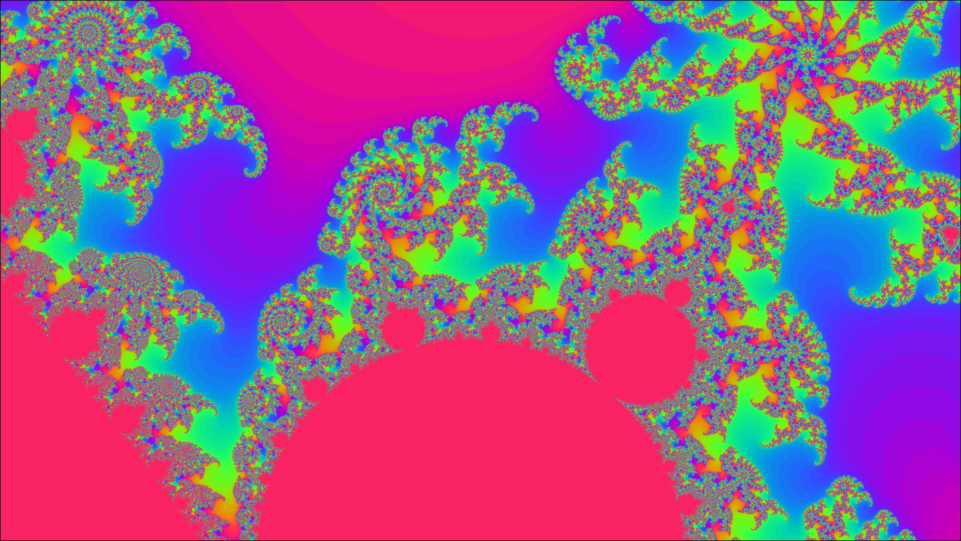

In [24]:
img = coloring.(collect(Z))

In [29]:
function kernel_mandelbrot!(Z)
	id = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = blockDim().x * gridDim().x

    Nx, Ny = size(Z)

    cind = CartesianIndices((Nx, Ny))


    for k=id:stride:Nx*Ny
        i = cind[k][1]
        j = cind[k][2]
        # Affine transformation
        # Screen space to world space
        x = ax*j + bx
        y = ay*i + by
        # Mandelbrot
        c = x + y*im
        z = c
        iterations = 0
        while CUDA.abs2(z) < 400.0 && iterations < max_iter
           z = z^2 + c 
           iterations += 1
        end
        @inbounds Z[i, j] = iterations
    end

    return nothing
end

kernel_mandelbrot! (generic function with 1 method)

In [32]:
begin
    # Using the CUDA.jl occupancy API, from the example at
    # https://github.com/JuliaGPU/CUDA.jl/blob/cb4a6b03ff443a062212c7a8aad260cfbf134410/src/indexing.jl#L37
    Z2 = CuArray{Float64}(undef, height, width);
    # Manual invocation, with fixed set of threads:
    # CUDA.@sync @cuda threads=1024 kernel_mandelbrot!(Z2);

    kernel = @cuda name="mandelbrot" launch=false kernel_mandelbrot!(Z2)
    config = launch_configuration(kernel.fun)
    threads = Base.min(length(Z2), config.threads)
    blocks = cld(length(Z2), threads) 
    # The @benchmark macro is optional
    @benchmark CUDA.@sync kernel(Z2; threads=threads, blocks=blocks)
end

BenchmarkTools.Trial: 15 samples with 1 evaluation.
 Range (min … max):  336.000 ms … 368.551 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     336.020 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   338.490 ms ±   8.351 ms  ┊ GC (mean ± σ):  0.35% ± 1.34%

  █                                                              
  █▁▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▁
  336 ms           Histogram: frequency by time          369 ms <

 Memory estimate: 21.13 MiB, allocs estimate: 692457.

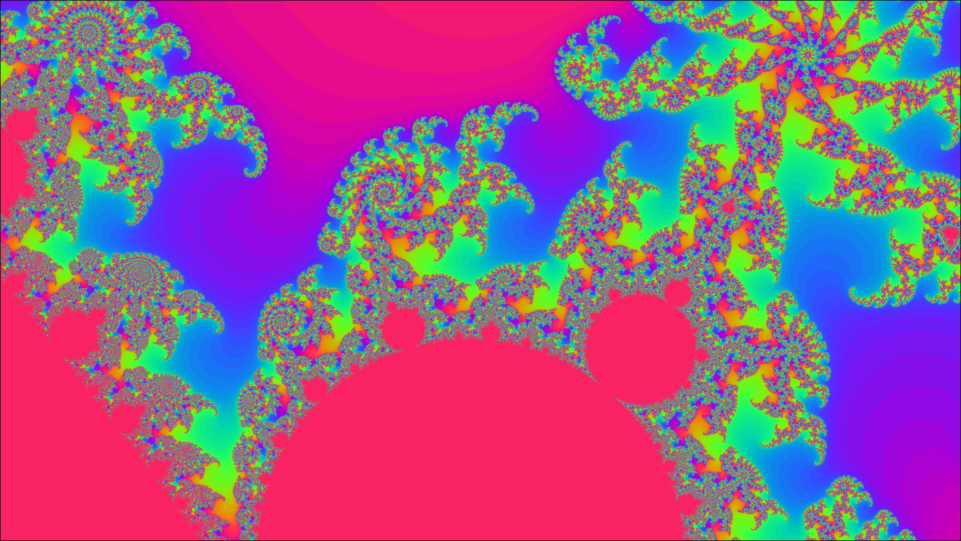

In [33]:
img2 = coloring.(collect(Z2))
#save("mandelbrot_CUDA_kernel.png", img2) optionally save image